In [1]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import networkx as nx

# reading input log file
# import ruamel.yaml
import yaml

import math
from scipy.stats import rankdata

test_name = "summer_sam_seq12f9s"
# 12p12f9s 
# summer_sam_seq6f9s summer_sam_seq12f9s
# seq9f9s 1p9f9s_run seq6f3s seq12f9s seq12f9s
# ddmd_12p4s_short ddmd_12p4s

stat_path=f"../example_stat/{test_name}"
image_path=f"{stat_path}/images"

In [2]:
# # Not used lib

# import re
# import ast
# import sys
# import traceback
# from csv import excel
# from collections import Counter
# import pandas as pd

# Improve Functions
## TODO
- MAYBE: Add adjustment of label to full label, file-task label, and no lables

## DONE
- DONE: Add task start option for graphs
    - Be careful about adding the required files??!!
- DONE: Add task cutoff option for graphs 
- DONE: (Maybe) add time for x-axis
- DONE: store the statistics to edges!!!

In [27]:
SELECT_STAGE_START = 8
SELECT_STAGE_END = 8

# TODO: modify for parallel tasks
TASK_ORDER_LIST = {
    "run_idfeature": 0,
    "run_tracksingle": 1,
    "run_gettracks": 2,
    "run_trackstats": 3,
    "run_identifymcs": 4,
    "run_matchpf": 5,
    "run_robustmcs": 6,
    "run_mapfeature": 7,
    "run_speed": 8
}

# TASK_ORDER_LIST = {
#     "openmm-0000": 0,"openmm-0001": 0,"openmm-0002": 0,
#     "openmm-0003": 0,"openmm-0004": 0,"openmm-0005": 0,
#     "openmm-0006": 0,"openmm-0007": 0,"openmm-0008": 0,
#     "openmm-0009": 0,"openmm-0010": 0,"openmm-0011": 0,
#     "aggregate": 1,
#     "train": 2,
#     "inference": 3,
# }

def correct_end_stage(select_end):
    # check if SELECT_STAGE_END is in TASK_ORDER_LIST
    max_order = max(TASK_ORDER_LIST.values())
    if select_end > max_order:
        # raise ValueError("SELECT_STAGE_END is not in TASK_ORDER_LIST")
        select_end = max_order
        print("SELECT_STAGE_END is not in TASK_ORDER_LIST, set to max order: {}".format(max_order))
    return select_end

SELECT_STAGE_END = correct_end_stage(SELECT_STAGE_END)

def remove_unwanted_tasks(map_dict):
    """Remove unwanted tasks from dictionary"""
    for task in list(map_dict.keys()):
        if task not in TASK_LISTS:
            map_dict.pop(task)
    return map_dict

TASK_LISTS = []
for task, order in TASK_ORDER_LIST.items():
    if SELECT_STAGE_END == -1:
        TASK_LISTS = list(TASK_ORDER_LIST.keys())
    else:
        if order <= SELECT_STAGE_END and order >= SELECT_STAGE_START:
            TASK_LISTS.append(task)



TASK_LISTS


['run_speed']

In [4]:

import os
import re

# data and load related methods
def humansize(nbytes):
    if nbytes != 0:
        suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
        i = 0
        while nbytes >= 1000 and i < len(suffixes)-1:
            nbytes /= 1000.
            i += 1
        f = ('%.2f' % nbytes).rstrip('0').rstrip('.')

        return '%s %s' % (f, suffixes[i])
    else:
        return 0

def humanbw(nbytes):
    if nbytes != 0:
        suffixes = ['B/s', 'KB/s', 'MB/s', 'GB/s', 'TB/s', 'PB/s']
        i = 0
        while nbytes >= 1000 and i < len(suffixes)-1:
            nbytes /= 1000.
            i += 1
        f = ('%.2f' % nbytes).rstrip('0').rstrip('.')
        return '%s %s' % (f, suffixes[i])
    else:
        return 0
    
def search_files_with_name(directory, pattern):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if re.search(pattern, file) and ('.yaml' in file or '.yml' in file):
                file_list.append(os.path.join(root, file))
                #print(os.path.join(root, file))
    return file_list

def load_vfd_yaml(vfd_files):
    # loag into {file_name:yaml_data} format
    ret_dict = {}
    tmp_dict = {}
    for f in vfd_files:
        if '.yaml' in f or '.yml' in f:
            with open(f, "r") as stream:
                print(f"loading {f}")
                
                try:
                    tmp_dict = yaml.safe_load(stream)
                    ret_dict[f] = tmp_dict
                    # print(tmp_dict)
                except yaml.YAMLError as exc:
                    print(exc)
                    print("Error loading yaml file")
                    exit(1)
    return ret_dict


# Read in task_to_file mapping yaml file
def load_task_file_map(test_name):
    task_file_map = {}
    with open(f"{stat_path}/{test_name}-task_to_file.yaml", "r") as stream:
        try:
            task_file_map = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    return task_file_map

def display_all_nodes_attr(G):
    for node in G.nodes():
        print(f"Node Name: {node}")
        print(f"- Order: {G.nodes[node]['order']} - Type: {G.nodes[node]['type']} - Position: {G.nodes[node]['pos']}")
        # print(f"- Statistics: {G.nodes[node]['stat']}")
    


In [5]:
# Graph Related Code
def draw_graph(G, test_name, prefix="", save=False):
    plt.figure(figsize=(80, 20))
    pos = {node: data['pos'] for node, data in G.nodes(data=True)}
    # Draw the graph with node labels
    nx.draw_networkx(G, pos=pos, with_labels=True, node_color='lightblue', edge_color='gray')

    if save:
        out_file_name=f"{test_name}-vol-networkx.png"
        if prefix != "": out_file_name=f"{prefix}-{test_name}-vol-networkx.png"
        
        save_image_path=f"../example_stat/{test_name}/{out_file_name}"
        plt.savefig(save_image_path)
    
    # Show the graph
    plt.show()
    
def add_task_file_nodes(G, stat_dict):
    edge_stats = {}

    for stat_file, stat_list in stat_dict.items():
        # print(stat_file)
        for li in stat_dict[stat_file]:
            k = list(li.keys())[0]
            if 'file' in k: # look for file entries
                task_name = li[k]['task_name']
                if task_name in TASK_LISTS: # select task entries
                    parts = k.split("-")
                    # node_name = f"{k} : {li[k]['file_name']}"
                    access_type = li[k]['access_type']
                    file_name = os.path.basename(li[k]['file_name']) #li[k]['file_name']
                    node_order = int(parts[1])
                    
                    # node_name = file_name # TODO: currently treat 'read_write' as 'write_only'
                    
                    if access_type == 'read_only': # Initial input files
                        
                        # add task node statistics
                        if not G.has_node(task_name):
                            node_attrs = {task_name: {'rpos':0, 'order': node_order, 'type':'task' }} # task has no stat
                            G.add_node(task_name, pos=(0,0))
                            nx.set_node_attributes(G, node_attrs)
                        if not G.has_node(file_name):
                            G.add_node(file_name, pos=(0,node_order))
                            node_attrs = {file_name: {'rpos':0, 'order': 0, 'type':'file'}}
                            nx.set_node_attributes(G, node_attrs)
                        # add edges
                        if not G.has_edge(file_name, task_name):
                            edge_stats[(file_name, task_name)] = {'access_type': access_type, 'stat': li[k]}
                        
                    elif access_type == 'write_only' or access_type == 'read_write': # Intermediate files
                        # add task node statistics
                        if not G.has_node(task_name):
                            node_attrs = {task_name: {'rpos':0, 'order': node_order, 'type':'task'}} # task has no stat
                            G.add_node(task_name, pos=(0,0))
                            nx.set_node_attributes(G, node_attrs)
                        if not G.has_node(file_name):
                            G.add_node(file_name, pos=(0,node_order))
                            node_attrs = {file_name: {'rpos':0, 'order': 0, 'type':'file'}}
                            nx.set_node_attributes(G, node_attrs)
                        
                        if not G.has_edge(task_name, file_name):
                            edge_stats[(task_name, file_name)] = {'access_type': access_type, 'stat': li[k]}
                    else:
                        print(f"Unknown access_type: {access_type}")
    G.add_edges_from(edge_stats.keys())
    nx.set_edge_attributes(G, edge_stats)

        
def set_task_position(G, tfe_dic):
    skip_pos = 2
    task_start_pos = 1
    task_order_cnt = {}
    prev_task_order = 0
    # task_file_edges dictionay
    for task_name,v in tfe_dic.items():
        task_order = v['order']
        print(f"task_name: {task_name}, task_order: {task_order}")

        # Account for parallel tasks
        if task_order > prev_task_order:
            task_start_pos += skip_pos

        if task_order in task_order_cnt:
            task_order_cnt[task_order] += 1
        else:
            task_order_cnt[task_order] = 0
        
        if task_name in G.nodes:
            node_attrs = G.nodes[task_name]
            print(f"node {task_name} : {node_attrs}, pos: {node_attrs['pos']}")
            node_attrs['order'] = task_order # update task order
            node_attrs['pos'] = (task_start_pos,task_order_cnt[task_order]) # add task position
            if node_attrs['rpos'] == 0:
                node_attrs['rpos'] = 1 # add task position
                nx.set_node_attributes(G, node_attrs) # update node attributes
                print(f"node : {task_name}, pos: {node_attrs['pos']}")
            
        else:
            node_attrs = {task_name: {'rpos':1, 'order': task_order, 'type':'task', 'stat':v}}
            position = (task_order,task_order_cnt[task_order])
            G.add_node(task_name, pos=position)
            nx.set_node_attributes(G, node_attrs)
            print(f"node {task_name} : {node_attrs}, pos: {position}")
        
        prev_task_order = task_order
        

def set_file_position(G, map_dic):

    # edge_list = []
    prev_task_x = 0
    
    for task_name, rw_info in map_dic.items():
        
        input_files = rw_info['input']
        task_x = G.nodes[task_name]['pos'][0]

        for i, file_path in enumerate(input_files):
            file_name = os.path.basename(file_path)
            # account for parallelly accessed files
            if prev_task_x == task_x:
                file_y = G.nodes[task_name]['pos'][1]
            else:
                file_y = i
            
            if G.nodes[file_name]['rpos'] == 0:
                G.nodes[file_name]['pos'] = (task_x - 1, file_y)
                G.nodes[file_name]['rpos'] = 1
                # print(f"{file_name} position updated to {G.nodes[file_name]['pos']}")
    
        output_files = rw_info['output']
        for i, file_path in enumerate(output_files):
            file_name = os.path.basename(file_path)
            # account for parallelly accessed files
            if prev_task_x == task_x:
                file_y = G.nodes[task_name]['pos'][1]
            else:
                file_y = i
            if G.nodes[file_name]['rpos'] == 0:
                G.nodes[file_name]['pos'] = (task_x + 1, file_y)
                G.nodes[file_name]['rpos'] = 1
                # print(f"{file_name} position updated to {G.nodes[file_name]['pos']}")
        prev_task_x = task_x
    # G.add_edges_from(edge_list)
    
    return G


In [6]:
vfd_files = search_files_with_name(stat_path, "vfd")
# vfd_files = vfd_files[0:1]
print(vfd_files)


vfd_dict = load_vfd_yaml(vfd_files)
# print(vfd_dict)

print("loading yaml done")



['../example_stat/summer_sam_seq12f9s/170202_vfd-data-stat.yaml']
loading ../example_stat/summer_sam_seq12f9s/170202_vfd-data-stat.yaml
loading yaml done


In [28]:
G_VFD = nx.DiGraph()

add_task_file_nodes(G_VFD, vfd_dict)

In [29]:


task_file_map = load_task_file_map(test_name)
task_file_map = remove_unwanted_tasks(task_file_map)
# print(task_file_map)

# for task, stat in task_file_map.items():
#     print(f"{task} : {stat}")


set_task_position(G_VFD, task_file_map)

task_name: run_speed, task_order: 9
node run_speed : {'pos': (0, 0), 'rpos': 0, 'order': 174, 'type': 'task'}, pos: (0, 0)
node : run_speed, pos: (3, 0)


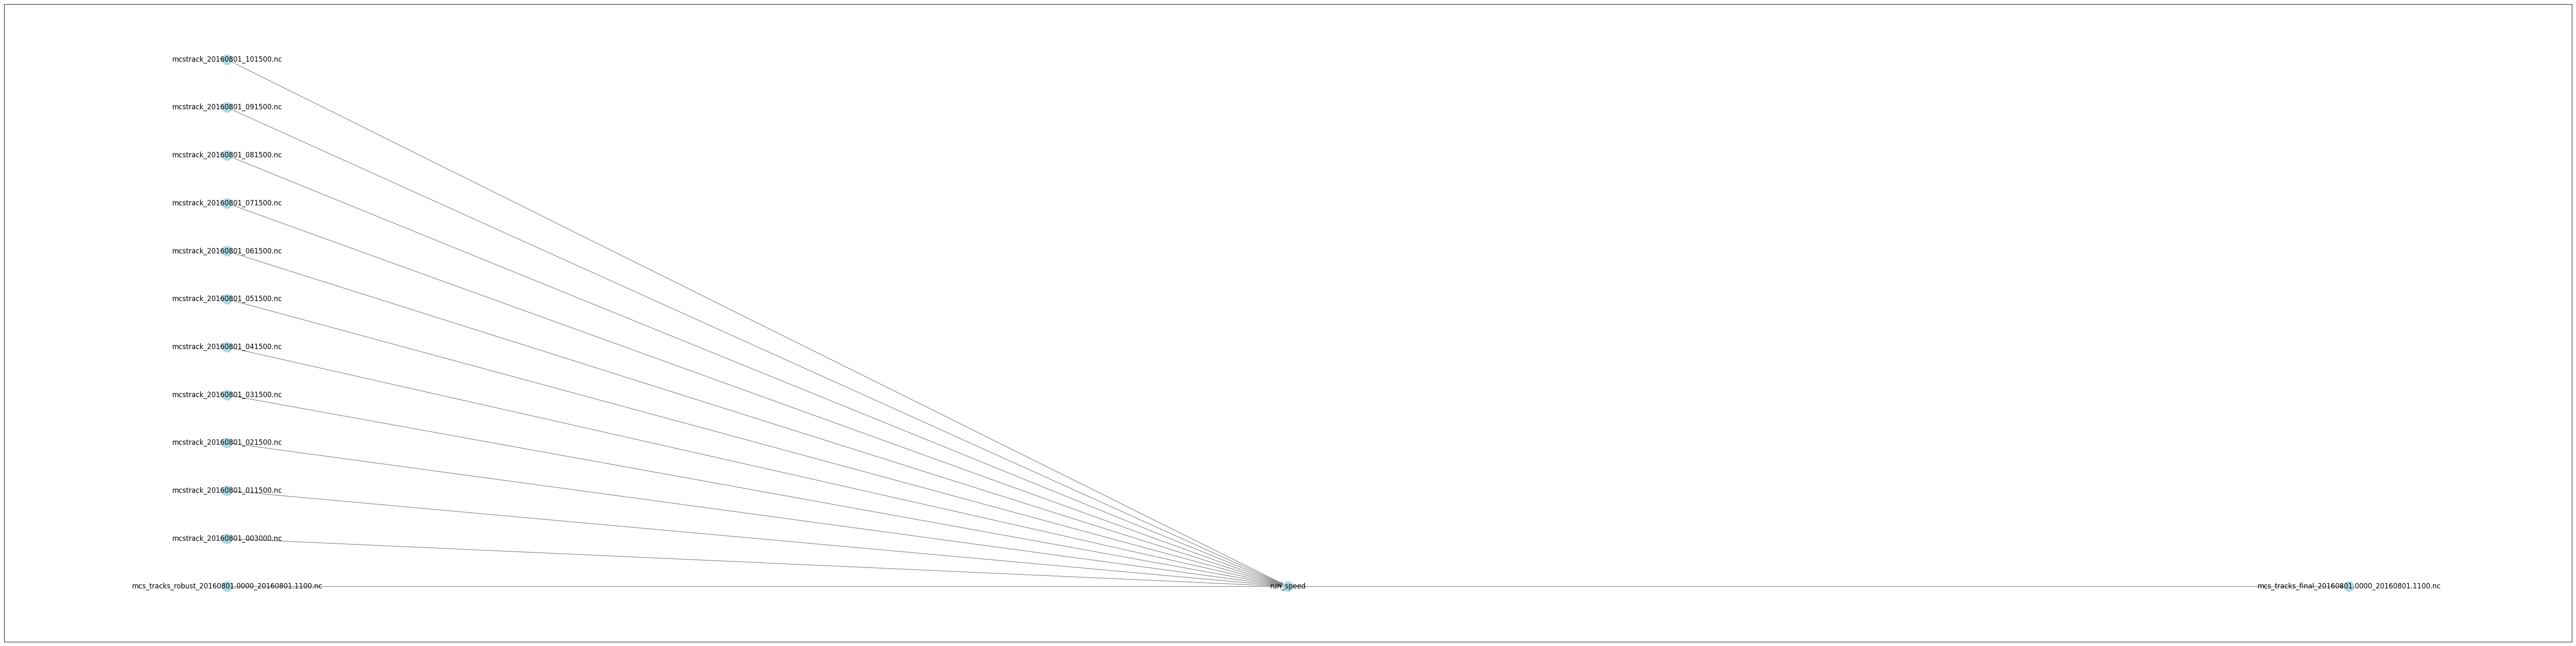

In [30]:
# display_all_nodes_attr(G_VFD)

# # print(task_file_map)
# for task, file_stat in task_file_map.items():
#     print(f"{task}: {file_stat}")

G_VFD = set_file_position(G_VFD, task_file_map)
# display_all_nodes_attr(G_VFD)
# print(f"G_VFD nodes: {G_VFD.nodes}")

# for e in G_VFD.edges:
#     print(e)

draw_graph(G_VFD, test_name, prefix=f'{(SELECT_STAGE_END+1)}s', save=True)

# Add networkx to Sankey diagram

## Statistics for Sankey
Below are needed edge attributes before generating the sankey diagram:
- access_cnt : The total file/dataset access count 
- access_size : The total read and write access size
- operation : The operation type : read, write, read_write
- bandwidth : Get the per access size and time, then calculate the bandwidth. Average the bandwidth if multiple accesses. (TODO: currently only recording one access size and time)




In [31]:
def prepare_sankey_stat(G):
    all_edge_attr = nx.get_edge_attributes(G,'stat')
    sankey_edge_attr = {}
    for edge, stat in all_edge_attr.items():
        access_cnt = stat['file_read_cnt'] + stat['file_write_cnt']
        acesss_size = stat['total_io_bytes']
        access_time_in_sec = (stat['close_time'] - stat['open_time'])/1000000
        bandwidth = acesss_size / access_time_in_sec
        position = G.nodes[edge[1]]['pos']
        
        # data access cnt
        data_stat = stat['data']['H5FD_MEM_DRAW']
        data_access_bytes = data_stat['read_bytes'] + data_stat['write_bytes']
        data_access_cnt = data_stat['read_cnt'] + data_stat['write_cnt']
        # metadata access cnt
        metadata_access_bytes = acesss_size - data_access_bytes
        metadata_access_cnt = access_cnt - data_access_cnt
        
        edge_attr = {
                'position': position,
                'access_cnt': access_cnt,
                'access_size': acesss_size,
                'data_access_size': data_access_bytes,
                'data_access_cnt': data_access_cnt,
                'metadata_access_size': metadata_access_bytes,
                'metadata_access_cnt': metadata_access_cnt,
                'operation': stat['access_type'],
                'bandwidth': bandwidth}
        sankey_edge_attr[edge] = edge_attr
    
    nx.set_edge_attributes(G, sankey_edge_attr)

prepare_sankey_stat(G_VFD)

# edge_attr=['access_cnt','access_size','operation','bandwidth']
# attr_cnt = nx.get_edge_attributes(G_VFD,edge_attr[0])
# attr_size = nx.get_edge_attributes(G_VFD,edge_attr[1])
# attr_op = nx.get_edge_attributes(G_VFD,edge_attr[2])
# attr_bw = nx.get_edge_attributes(G_VFD,edge_attr[3])
# print('Edge attr_cnt: ', attr_cnt)
# print('Edge attr_size: ', attr_size)
# print('Edge attr_op: ', attr_op)
# print('Edge attr_bw: ', attr_bw)

In [32]:
def in_file_time_to_x(G,task):
    in_edges = list(G.in_edges(task))
    # print(f'{task} In edges: ', in_edges)
    in_files = [edge[0] for edge in in_edges]

    # get in files x_pos
    in_files_x_pos = [G.nodes[file]['pos'][0] for file in in_files]
    if in_files_x_pos == []:
        return
        
    # remove files not in the same curr_x_pos
    curr_x_pos = max(in_files_x_pos)
    in_files = [file for file in in_files if G.nodes[file]['pos'][0] == curr_x_pos and G.nodes[file]['rpos'] == 1]
        
    if in_files == []:
        return
    
    # get open time ranks from edge stats
    in_files_opentime = [G.edges[file,task]['stat']['open_time'] for file in in_files]
    
    # # get open time ranks
    # in_files_opentime = [G.nodes[file]['stat']['open_time'] for file in in_files]
    if len(in_files_opentime) > 1:
        in_files_opentime_rank = rankdata(in_files_opentime)
        # only normalize between 0 and 0.5, save space between task
        normalized_opentime_ranks = [0.5 * (rank - 1) / (len(in_files_opentime_rank) - 1) for rank in in_files_opentime_rank]
    else:
        normalized_opentime_ranks = [0.0]

    for i,file in enumerate(in_files):
        new_x_pos = curr_x_pos + normalized_opentime_ranks[i]
        y_pos = G.nodes[file]['pos'][1]
        G.nodes[file]['pos'] = (new_x_pos, y_pos)
        # G.nodes[file]['pos'][1] = G.nodes[task]['pos'][1]
        print(f'{file} New pos: ', G.nodes[file]['pos'])
        G.nodes[file]['rpos'] = 2 # mark as added time to x_pos


def out_file_time_to_x(G,task):
    out_edges = list(G.out_edges(task))
    out_fiels = [edge[1] for edge in out_edges]

    # get out files x_pos
    out_files_x_pos = [G.nodes[file]['pos'][0] for file in out_fiels]
    if out_files_x_pos == []:
        return

    # remove files not in the same curr_x_pos
    curr_x_pos = min(out_files_x_pos)
    out_files = [file for file in out_fiels if G.nodes[file]['pos'][0] == curr_x_pos and G.nodes[file]['rpos'] == 1]

    if out_files == []:
        return
    
    # # get close time ranks
    # out_files_closetime = [G.nodes[file]['stat']['close_time'] for file in out_fiels]

    # get close time ranks from edge stats
    out_files_closetime = [G.edges[task,file]['stat']['close_time'] for file in out_files]

    if len(out_files_closetime) > 1:
        out_files_closetime_rank = rankdata(out_files_closetime)
        # only normalize between 0 and 0.5, save space between task
        normalized_closetime_ranks = [0.5 * (rank - 1) / (len(out_files_closetime_rank) - 1) for rank in out_files_closetime_rank]
    else:
        normalized_closetime_ranks = [0.0]
    
    for i,file in enumerate(out_fiels):
        new_x_pos = curr_x_pos - normalized_closetime_ranks[i]
        y_pos = G.nodes[file]['pos'][1]
        G.nodes[file]['pos'] = (new_x_pos, y_pos)
        # G.nodes[file]['pos'][1] = G.nodes[task]['pos'][1]
        print(f'{file} New pos: ', G.nodes[file]['pos'])
        G.nodes[file]['rpos'] = 2

    # print(f'{task} Out files: ', out_fiels)
        
def time_to_file_x_pos(G):
    all_tasks = list([node for node in G.nodes() if G.nodes[node]['type'] == 'task'])
    print('All tasks: ', all_tasks)
    for i,task in enumerate(all_tasks):
        # get in edges files time to x_pos
        in_file_time_to_x(G,task)
        # get out edges files time to x_pos
        if i == len(all_tasks) - 1:
            out_file_time_to_x(G,task)

time_to_file_x_pos(G_VFD)

All tasks:  ['run_speed']
mcs_tracks_robust_20160801.0000_20160801.1100.nc New pos:  (2.5, 0)
mcstrack_20160801_003000.nc New pos:  (2.0, 1)
mcstrack_20160801_011500.nc New pos:  (2.0454545454545454, 2)
mcstrack_20160801_021500.nc New pos:  (2.090909090909091, 3)
mcstrack_20160801_031500.nc New pos:  (2.1363636363636362, 4)
mcstrack_20160801_041500.nc New pos:  (2.1818181818181817, 5)
mcstrack_20160801_051500.nc New pos:  (2.227272727272727, 6)
mcstrack_20160801_061500.nc New pos:  (2.2727272727272725, 7)
mcstrack_20160801_071500.nc New pos:  (2.3181818181818183, 8)
mcstrack_20160801_081500.nc New pos:  (2.3636363636363638, 9)
mcstrack_20160801_091500.nc New pos:  (2.409090909090909, 10)
mcstrack_20160801_101500.nc New pos:  (2.4545454545454546, 11)
mcs_tracks_final_20160801.0000_20160801.1100.nc New pos:  (4.0, 0)


In [33]:
# Sankey related codes
EDGE_COLOR_RGBA = {
    'none' : {'r':180, 'g':180, 'b':180}, #grey for open/close/meta
    'read_only' : {'r':150, 'g':190, 'b':220},
    'write_only' : {'r':150, 'g':190, 'b':220},
    'read_write' : {'r':150, 'g':190, 'b':220}, # TODO: currently showing same as write
    # 'read_write' : {'r':220, 'g':220, 'b':220},
    # 'write' : {'r':140, 'g':210, 'b':220},
}

# color names : https://www.w3schools.com/colors/colors_names.asp
COLOR_MAP = {"task": "Red", # read
            "dataset": "Gold", # yellow
            "file": "Blue", # blue
            "none": "grey",
            }

OPACITY = 0.2

def get_xy_position(G):
    pos_dict = nx.get_node_attributes(G,'pos')

    x_dict = {}
    y_dict = {}
    for n, pos in pos_dict.items():
        x_dict[n] = pos[0]
        y_dict[n] = pos[1]
    
    # shift x position to start from 0
    x_base= min(x_dict.values())
    x_dict = {k: v-x_base for k, v in x_dict.items()}

    # normalize x positions
    # xf=1.0/(max(x_dict.values()))
    # x_normalized = {k: v*xf for k, v in x_dict.items() }
    x_max = max(x_dict.values())
    x_min = min(x_dict.values())
    x_normalized = {k: 0.01 + 0.99 * (v - x_min) / (x_max - x_min) for k, v in x_dict.items()}

    # normalize y positions
    y_max = max(y_dict.values())
    y_min = min(y_dict.values())
    # Noamalize y positions between 0 and 0.9
    y_normalized = {k: 0.01 + 0.99 * (v - y_min) / (y_max - y_min) for k, v in y_dict.items()}
    
    # yf=1.0/(max(y_dict.values()))
    # y_normalized = {k: v*yf for k, v in y_dict.items() }
    
    return x_normalized, y_normalized

def get_nodes_for_sankey(G, rm_tags=[],label_on=True):
    node_dict_ref = {}
    node_dict_for_sankey = {'label': [], 'color':[], 'x':[], 'y':[] }
    x_pos, y_pos = get_xy_position(G)
    
    for idx, (node_name, attr) in enumerate(G.nodes(data=True)):
        # node_type = 'file' if node_name[-4:] == 'residue_100.h5' else 'task'
        # print(f"{idx}, ({node_name}, {attr})")
        
        node_type = attr['type']
        if node_name in node_dict_ref:
            print(node_name, "==duplicate==")
        node_dict_ref[node_name] = {'idx':idx, 'type':node_type}

        #sankey
        if label_on :  
            # node_label = node_name + f" {G.nodes[node_name]['pos']} ({x_pos[node_name]:.2f}, {y_pos[node_name]:.2f})"
            node_label = node_name
            node_dict_for_sankey['label'].append(node_label)
        node_dict_for_sankey['color'].append(COLOR_MAP[node_type])
        node_dict_for_sankey['x'].append(x_pos[node_name])
        node_dict_for_sankey['y'].append(y_pos[node_name])
    return node_dict_for_sankey, node_dict_ref


def edge_color_scale(attr_bw, attr_op, bw, op):
    range = 100

    base_color_dict = {}
    if op in EDGE_COLOR_RGBA.keys():
        base_color_dict = EDGE_COLOR_RGBA[op]
        r = base_color_dict['r']
        g = base_color_dict['g']
        b = base_color_dict['b']
    else:
        base_color_dict = EDGE_COLOR_RGBA['none']
        r = base_color_dict['r']
        g = base_color_dict['g']
        b = base_color_dict['b']
        color_str = f"rgba({r}, {g}, {b}, {OPACITY})"
        return color_str

    edges = []
    for k,v in attr_op.items():
        if v == op:
            edges.append(k)
    # bw_list = list(set(attr_bw.values()))
    bw_list = [attr_bw[x] for x in edges]
    bw_list.sort()
    # print(bw_list)
        
    color_ranks = rankdata(bw_list,method='dense')
    color_ranks = [float(i)/max(color_ranks) for i in color_ranks] # normalize

    my_rank = color_ranks[bw_list.index(bw)]

    color_change = my_rank *range #(my_rank-1)
    op_change = (my_rank/max(color_ranks)) * 0.5 + 0.2
    color_str = f"rgba({r-color_change/1.5}, {g-color_change/1.5}, {b-color_change/1.5}, {op_change})"

    # print(f"{color_str} rank={my_rank} sqrt={math.sqrt(my_rank)} change={color_change}")
    return color_str

def get_links_for_sankey(G, node_dict_ref, 
                         edge_attr=['access_cnt','access_size','operation','bandwidth', 'data_access_size', 'data_access_cnt', 'metadata_access_size', 'metadata_access_cnt'], 
                         rm_tags=[],val_sqrt=True):
    
    link_dict_for_sankey = {'source':[], 'target':[], 'value':[], 'label': [], 'color': []}
    #'hoverinfo': "all"
    #'line_width':[], # shows strokeWidth of the edges
    
    attr_cnt = nx.get_edge_attributes(G,edge_attr[0])
    attr_size = nx.get_edge_attributes(G,edge_attr[1])
    attr_op = nx.get_edge_attributes(G,edge_attr[2])
    attr_bw = nx.get_edge_attributes(G,edge_attr[3])
    attr_data_size = nx.get_edge_attributes(G,edge_attr[4])
    attr_data_cnt = nx.get_edge_attributes(G,edge_attr[5])
    attr_metadata_size = nx.get_edge_attributes(G,edge_attr[6])
    attr_metadata_cnt = nx.get_edge_attributes(G,edge_attr[7])
    
    
    # min_size = min(attr_size.values())
    
    # print(attr_dict)
    for u, v, attr in G.edges(data=True):
        # print(u, v, attr)
        u_idx = node_dict_ref[u]['idx']
        v_idx = node_dict_ref[v]['idx']
        link_dict_for_sankey['source'].append(u_idx)
        link_dict_for_sankey['target'].append(v_idx)

        cnt = attr_cnt[(u,v)]
        size = attr_size[(u,v)]
        if val_sqrt: graph_size = math.sqrt(math.sqrt(size))  #math.sqrt(math.sqrt(size))  math.sqrt(size) 
        else: graph_size = size
        
        if cnt == 0: cnt = 1
        if size == 0: graph_size = 1
        
        op = attr_op[(u,v)]

        # get edge color based on bandwidth
        link_dict_for_sankey['value'].append(graph_size)
        # _str = f"ave_acc_size: {humansize(size/cnt)} op: {op}"
        bw = attr_bw[(u,v)]
        _str = (f"Access Volume : {humansize(size)} <br />"
            + f"Access Count : {cnt} <br />"
            + f"Average Access Size : {humansize(size/cnt)} <br />"
            + F"HDF5 Data Access Count : {attr_data_cnt[(u,v)]} <br />"
            + f"Average HDF5 Data Access Size : {humansize(attr_data_size[(u,v)]/attr_data_cnt[(u,v)])} <br />"
            + F"HDF5 Metadata Access Count : {attr_metadata_cnt[(u,v)]} <br />"
            + f"Average HDF5 Metadata Access Size : {humansize(attr_metadata_size[(u,v)]/attr_metadata_cnt[(u,v)])} <br />"
            + f"Operation : {op}<br />"
            +f"Bandwidth : {humanbw(bw)}")
        
        link_dict_for_sankey['label'].append(_str)

        link_dict_for_sankey['color'].append(edge_color_scale(attr_bw, attr_op, bw, op)) # get the last operation
        
        # link_dict_for_sankey['acc_cnt'].append(cnt)
    
    print(f"bandwidth range: {humanbw(min(attr_bw.values()))} ~ {humanbw(max(attr_bw.values()))}")
        
    return link_dict_for_sankey

def selected_graph(node_name, G):
    # this is not used
    selected_G = nx.DiGraph()
    search_nodes = [node_name]
    while len(search_nodes) > 0:
        next_set = []
        for n in search_nodes:
            for edge in G.edges(n):
                val = G.edges[edge]['value']
                selected_G.add_edges_from([edge], value=val)
                #print(selected_G.nodes)
            next_set += [x for x in G.neighbors(n)]
        search_nodes = next_set
    return selected_G

In [41]:
vfd_nodes, vfd_nodes_dict = get_nodes_for_sankey(G_VFD, label_on=True)

# print(vfd_nodes)

vfd_links = get_links_for_sankey(G_VFD, vfd_nodes_dict, val_sqrt=True)
fig = go.Figure(go.Sankey(
            node = vfd_nodes,
            link = vfd_links, orientation='h'))

fig.update_layout(
    autosize=False,
    width=1400,
    height=800,
    margin=dict(
        l=200,
        r=200,
        b=100,
        t=200,
        pad=2
    ),
    font=dict(size=18),
)

    
fig.show()
save_html_path = f"{stat_path}/vfd-{(SELECT_STAGE_END+1)}s-{test_name}-sankey-labeled-s9.html"
fig.write_html(save_html_path)
print(f"Sankey saved to {save_html_path}")

bandwidth range: 165.33 KB/s ~ 4.89 MB/s


Sankey saved to ../example_stat/summer_sam_seq12f9s/vfd-9s-summer_sam_seq12f9s-sankey-labeled-s9.html


In [35]:
import numpy as np

# vfd_links
def show_overall_stats(G):
    
    # overall stats
    access_size = nx.get_edge_attributes(G, 'access_size')
    access_cnt = nx.get_edge_attributes(G, 'access_cnt')
    bandwidth = nx.get_edge_attributes(G, 'bandwidth')
    total_access_size = sum(access_size.values())
    
    # get all nodes that are tasks
    task_nodes = [n for n in G.nodes() if G.nodes[n]['type'] == 'task']
    # get all task nodes that are order = 0
    task_nodes_0 = [n for n in task_nodes if G.nodes[n]['order'] == 0]
    # get all in_edges of task_nodes_0
    in_edges = []
    for n in task_nodes_0:
        in_edges += list(G.in_edges(n))
    
    # get initia; input size from in_edges
    initial_input_size = sum([G.edges[e]['access_size'] for e in in_edges])

    
    stat_str = 'Total number of links: {}\n'.format(len(access_size))
    stat_str += f"Total I/O size: {humansize(total_access_size)}\n"
    stat_str += f"Total I/O count: {sum(access_cnt.values())}\n"
    stat_str += f"Total bandwidth: {humanbw(sum(bandwidth.values()))}\n"
    stat_str += f"Average I/O size: {humansize(total_access_size/sum(access_cnt.values()))}\n"
    
    # get medium I/O size
    stat_str += f"Medium I/O size: {humansize(np.median(list(access_size.values())))}\n"
    
    stat_str += f"Inital input size: {humansize(initial_input_size)}\n"
    
    return stat_str

stat_str = show_overall_stats(G_VFD)
print(stat_str)


Total number of links: 13
Total I/O size: 82.28 MB
Total I/O count: 24992
Total bandwidth: 32.07 MB/s
Average I/O size: 3.29 KB
Medium I/O size: 7.27 MB
Inital input size: 0



In [36]:
# Create a manual legend using annotations.

def add_legend_to_graph(fig,save_img=False):
    LEGEND_ITEMS = {
        "Tasks":{"color":"red", "text":"Tasks"},
        "Files":{"color":"blue", "text":"Files"},
        "Edges":{"color":"lightblue", "text":"File bandwidth, darker the color, higher the bandwidth"},
    }

    legend_items = [
        go.layout.Annotation(
            x=0.9,  # X-coordinate for legend item
            y=0.85 - i * 0.03,  # Y-coordinate for legend item (adjust for position)
            xref='paper',
            yref='paper',
            text=f"{item_type} - {LEGEND_ITEMS[item_type]['color']}",
            showarrow=False,
            font=dict(size=14, color=LEGEND_ITEMS[item_type]['color']),
            # bordercolor='grey',  # Set the border color for the legend box
            # borderwidth=1,  # Set the border width for the legend box
            bgcolor='rgba(255, 255, 255, 0.7)',  # Add a transparent background color
        )
        for i, item_type in enumerate(LEGEND_ITEMS.keys())
    ]
    fig.update_layout(annotations=legend_items)
    fig.show()
    if save_img:
        fig.write_html(f"{stat_path}/vfd-{(SELECT_STAGE_END+1)}s-{test_name}-sankey-annotated.html")
